# Optimizacion Industrial con Computacion Evolutiva
<b> Diplomatura de Especialización en Desarrollo de Aplicaciones con Inteligencia Artificial</b>

Dr. Edwin Villanueva (ervillanueva@pucp.edu.pe)

# Integrantes del Grupo
| Nombre | Correo Institucional |
|--------|-------------------|
| BARRIOS AEDO, JULIO ENRIQUE | f1499466@pucp.edu.pe |
| CARRANZA OLIVERA, CARLOS HUGO MARTÍN | a20163696@pucp.edu.pe |
| CHAVARRIA MUJICA, CARLOS EDUARDO | f1361256@pucp.edu.pe |
| CHAVARRIA MUJICA, PEDRO ANTONIO | f1361124@pucp.edu.pe |
| LAMADRID COTRINA, GIANCARLO | f1486337@pucp.edu.pe |

## 1. Carga y Preprocesamiento de Datos

In [52]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
from typing import List, Dict, Tuple

# Importar funciones utilitarias
from utils.horarios import horario_incluye_jueves_prohibido, validar_horarios_disponibles

# Configuración para visualizaciones
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

In [16]:
# Datasets basados en el caso de estudio

# Dataset de Horarios
horarios_data = {
    'horario_id': ['H001', 'H002', 'H003', 'H004'],
    'horario': [
        'L-Mi-V 09:00 – 10:00',
        'L-Mi-V 10:00 – 11:00',
        'Ma-J 09:00 – 10:30',
        'Ma-J 10:30 – 12:00'
    ]
}
df_horarios = pd.DataFrame(horarios_data)

# Dataset de Profesores
profesores_data = {
    'profesor_id': ['P001', 'P002', 'P003', 'P004'],
    'nombre': [
        'Dr. Edwin Villanueva',
        'Mg. Layla Hirsh',
        'Dr. Manuel Tupia',
        'Mg. Cesar Aguilera'
    ],
    'horario_preferido': [None, 'H001', None, 'H002']
}
df_profesores = pd.DataFrame(profesores_data)

# Dataset de Aulas
aulas_data = {
    'aula_id': ['A001', 'A002', 'A003'],
    'capacidad': [45, 35, 25]
}
df_aulas = pd.DataFrame(aulas_data)

# Dataset de Cursos
cursos_data = {
    'curso_id': ['C001', 'C002', 'C003', 'C004', 'C005', 'C006', 'C007'],
    'curso': [
        'Fundamentos de programación',
        'Bases de Datos',
        'Algoritmia',
        'Sistemas de información',
        'Sistemas de Información 2',
        'Machine Learning',
        'Deep Learning'
    ],
    'cantidad_alumnos': [45, 45, 35, 30, 30, 25, 20],
    'lista_profesores': [
        'P001,P002,P003,P004',
        'P004',
        'P002,P003',
        'P003,P004',
        'P003,P004',
        'P001,P002',
        'P001'
    ]
}
df_cursos = pd.DataFrame(cursos_data)

In [17]:
# Preprocesar datos para facilitar su uso en el algoritmo

# Convertir lista de profesores de string a lista
df_cursos['lista_profesores'] = df_cursos['lista_profesores'].apply(lambda x: x.split(','))

# Crear diccionarios para acceso rápido
horarios_dict = df_horarios.set_index('horario_id')['horario'].to_dict()
profesores_dict = df_profesores.set_index('profesor_id')['nombre'].to_dict()
aulas_dict = df_aulas.set_index('aula_id')['capacidad'].to_dict()
cursos_dict = df_cursos.set_index('curso_id').to_dict('index')

# Crear listas de IDs para facilitar indexación
horarios_ids = list(df_horarios['horario_id'])
profesores_ids = list(df_profesores['profesor_id'])
aulas_ids = list(df_aulas['aula_id'])
cursos_ids = list(df_cursos['curso_id'])


## 2. Codificación del Problema

In [32]:
class CronogramaIndividuo:
    """
    Representa un individuo (cronograma) en el algoritmo genético.
    Cada gen representa la asignación de un curso: [aula_id, profesor_id, horario_id]
    """
    
    def __init__(self, genes=None):
        self.num_cursos = len(cursos_ids)
        if genes is None:
            self.genes = self.generar_genes_aleatorios()
        else:
            self.genes = genes
        self.fitness = None
        self.restricciones_incumplidas = None
        # Inicializar restricciones_incumplidas con valores por defecto
        self.restricciones_incumplidas = {
            'obligatorias': 0,
            'opcionales': 0,
            'eficiencia': 0,
            'preferencias': 0
        }
    
    def generar_genes_aleatorios(self):
        """Genera genes aleatorios respetando las restricciones de profesores válidos"""
        genes = []
        for curso_id in cursos_ids:
            curso_info = cursos_dict[curso_id]
            profesores_validos = curso_info['lista_profesores']
            
            aula = random.choice(aulas_ids)
            profesor = random.choice(profesores_validos)
            horario = random.choice(horarios_ids)
            
            genes.append([aula, profesor, horario])
        
        return genes
    
    def obtener_asignacion(self, curso_idx):
        """Obtiene la asignación de un curso específico"""
        return {
            'curso_id': cursos_ids[curso_idx],
            'aula_id': self.genes[curso_idx][0],
            'profesor_id': self.genes[curso_idx][1],
            'horario_id': self.genes[curso_idx][2]
        }
    
    def obtener_cronograma_completo(self):
        """Devuelve el cronograma completo como lista de diccionarios"""
        cronograma = []
        for i in range(self.num_cursos):
            asignacion = self.obtener_asignacion(i)
            curso_info = cursos_dict[asignacion['curso_id']]
            
            cronograma.append({
                'curso_id': asignacion['curso_id'],
                'curso': curso_info['curso'],
                'cantidad_alumnos': curso_info['cantidad_alumnos'],
                'aula_id': asignacion['aula_id'],
                'capacidad': aulas_dict[asignacion['aula_id']],
                'profesor_id': asignacion['profesor_id'],
                'profesor': profesores_dict[asignacion['profesor_id']],
                'horario_id': asignacion['horario_id'],
                'horario': horarios_dict[asignacion['horario_id']]
            })
        
        return cronograma
    
    def __str__(self):
        return f"Individuo(fitness={self.fitness}, genes={self.genes})"

# Crear un individuo de ejemplo
individuo_ejemplo = CronogramaIndividuo()
print("Individuo de ejemplo creado:")
print(f"Genes: {individuo_ejemplo.genes}")
print("\nCronograma del individuo:")
cronograma_ejemplo = individuo_ejemplo.obtener_cronograma_completo()
for clase in cronograma_ejemplo:
    print(f"{clase['curso_id']}: {clase['aula_id']} - {clase['profesor_id']} - {clase['horario_id']}")

Individuo de ejemplo creado:
Genes: [['A001', 'P003', 'H004'], ['A001', 'P004', 'H003'], ['A003', 'P003', 'H002'], ['A001', 'P003', 'H002'], ['A003', 'P003', 'H001'], ['A001', 'P001', 'H004'], ['A003', 'P001', 'H004']]

Cronograma del individuo:
C001: A001 - P003 - H004
C002: A001 - P004 - H003
C003: A003 - P003 - H002
C004: A001 - P003 - H002
C005: A003 - P003 - H001
C006: A001 - P001 - H004
C007: A003 - P001 - H004


## 3. Función Fitness

In [33]:
def evaluar_fitness(individuo):
    """
    Evalúa el fitness de un individuo basado en restricciones obligatorias y opcionales.
    Mayor fitness = mejor solución
    """
    cronograma = individuo.obtener_cronograma_completo()
    
    # Inicializar contadores
    restricciones_obligatorias = 0
    restricciones_opcionales = 0
    puntuacion_eficiencia = 0
    puntuacion_preferencias = 0
    
    # === RESTRICCIONES OBLIGATORIAS ===
    
    # 1. Verificar conflictos de aula (misma aula, mismo horario)
    aula_horario_ocupacion = {}
    for clase in cronograma:
        clave = (clase['aula_id'], clase['horario_id'])
        if clave in aula_horario_ocupacion:
            restricciones_obligatorias += 1
        else:
            aula_horario_ocupacion[clave] = clase['curso_id']
    
    # 2. Verificar conflictos de profesor (mismo profesor, mismo horario)
    profesor_horario_ocupacion = {}
    for clase in cronograma:
        clave = (clase['profesor_id'], clase['horario_id'])
        if clave in profesor_horario_ocupacion:
            restricciones_obligatorias += 1
        else:
            profesor_horario_ocupacion[clave] = clase['curso_id']
    
    # 3. Verificar capacidad de aula
    for clase in cronograma:
        if clase['cantidad_alumnos'] > clase['capacidad']:
            restricciones_obligatorias += 1
    
    # 4. Verificar que el profesor puede dictar el curso
    for i, clase in enumerate(cronograma):
        curso_info = cursos_dict[clase['curso_id']]
        if clase['profesor_id'] not in curso_info['lista_profesores']:
            restricciones_obligatorias += 1
    
    # === RESTRICCIONES OPCIONALES ===
    
    # 1. Eficiencia de aula (capacidad cercana a cantidad de alumnos)
    for clase in cronograma:
        eficiencia = clase['cantidad_alumnos'] / clase['capacidad']
        if eficiencia >= 0.8:  # Muy eficiente
            puntuacion_eficiencia += 3
        elif eficiencia >= 0.6:  # Eficiente
            puntuacion_eficiencia += 2
        elif eficiencia >= 0.4:  # Moderadamente eficiente
            puntuacion_eficiencia += 1
        # Si eficiencia < 0.4, no se suma puntos
    
    # 2. Horarios preferidos de profesores
    for clase in cronograma:
        profesor_info = df_profesores[df_profesores['profesor_id'] == clase['profesor_id']].iloc[0]
        if pd.notna(profesor_info['horario_preferido']) and profesor_info['horario_preferido'] == clase['horario_id']:
            puntuacion_preferencias += 2
    
    # 3. Evitar jueves 10:00-14:00
    for clase in cronograma:
        if horario_incluye_jueves_prohibido(clase['horario']):
            restricciones_opcionales += 1
    
    # === CÁLCULO DEL FITNESS ===
    # Penalización fuerte por restricciones obligatorias
    fitness = 1000 - (restricciones_obligatorias * 100)
    
    # Penalización leve por restricciones opcionales
    fitness -= restricciones_opcionales * 10
    
    # Bonificación por eficiencia y preferencias
    fitness += puntuacion_eficiencia * 5
    fitness += puntuacion_preferencias * 3
    
    # Almacenar información de restricciones para análisis
    individuo.restricciones_incumplidas = {
        'obligatorias': restricciones_obligatorias,
        'opcionales': restricciones_opcionales,
        'eficiencia': puntuacion_eficiencia,
        'preferencias': puntuacion_preferencias
    }
    
    individuo.fitness = max(0, fitness)  # Asegurar que el fitness no sea negativo
    return individuo.fitness

# Evaluar el individuo de ejemplo
fitness_ejemplo = evaluar_fitness(individuo_ejemplo)
print(f"Fitness del individuo ejemplo: {fitness_ejemplo}")
print(f"Restricciones incumplidas: {individuo_ejemplo.restricciones_incumplidas}")

Fitness del individuo ejemplo: 550
Restricciones incumplidas: {'obligatorias': 5, 'opcionales': 4, 'eficiencia': 18, 'preferencias': 0}


## 4. Operadores Genéticos

In [34]:
def seleccion_torneo(poblacion, k=3):
    """
    Selección por torneo: elige k individuos al azar y retorna el mejor
    """
    torneo = random.sample(poblacion, min(k, len(poblacion)))
    return max(torneo, key=lambda x: x.fitness)

def seleccion_ruleta(poblacion):
    """
    Selección por ruleta: probabilidad proporcional al fitness
    """
    fitness_total = sum(ind.fitness for ind in poblacion)
    if fitness_total == 0:
        return random.choice(poblacion)
    
    punto_seleccion = random.uniform(0, fitness_total)
    suma_actual = 0
    
    for individuo in poblacion:
        suma_actual += individuo.fitness
        if suma_actual >= punto_seleccion:
            return individuo
    
    return poblacion[-1]  # Fallback

# Ejemplo de selección
poblacion_ejemplo = [CronogramaIndividuo() for _ in range(5)]
for ind in poblacion_ejemplo:
    evaluar_fitness(ind)

print("Población ejemplo:")
for i, ind in enumerate(poblacion_ejemplo):
    print(f"Individuo {i}: fitness = {ind.fitness}")

seleccionado_torneo = seleccion_torneo(poblacion_ejemplo)
seleccionado_ruleta = seleccion_ruleta(poblacion_ejemplo)

print(f"\nSeleccionado por torneo: fitness = {seleccionado_torneo.fitness}")
print(f"Seleccionado por ruleta: fitness = {seleccionado_ruleta.fitness}")

Población ejemplo:
Individuo 0: fitness = 455
Individuo 1: fitness = 435
Individuo 2: fitness = 636
Individuo 3: fitness = 467
Individuo 4: fitness = 865

Seleccionado por torneo: fitness = 636
Seleccionado por ruleta: fitness = 636


In [35]:
def cruzamiento_un_punto(padre1, padre2):
    """
    Cruzamiento de un punto: divide los cromosomas en un punto aleatorio
    """
    punto_cruce = random.randint(1, len(padre1.genes) - 1)
    
    genes_hijo1 = padre1.genes[:punto_cruce] + padre2.genes[punto_cruce:]
    genes_hijo2 = padre2.genes[:punto_cruce] + padre1.genes[punto_cruce:]
    
    # Reparar genes para asegurar que los profesores sean válidos
    genes_hijo1 = reparar_genes(genes_hijo1)
    genes_hijo2 = reparar_genes(genes_hijo2)
    
    return CronogramaIndividuo(genes_hijo1), CronogramaIndividuo(genes_hijo2)

def cruzamiento_dos_puntos(padre1, padre2):
    """
    Cruzamiento de dos puntos
    """
    punto1 = random.randint(1, len(padre1.genes) - 2)
    punto2 = random.randint(punto1 + 1, len(padre1.genes) - 1)
    
    genes_hijo1 = padre1.genes[:punto1] + padre2.genes[punto1:punto2] + padre1.genes[punto2:]
    genes_hijo2 = padre2.genes[:punto1] + padre1.genes[punto1:punto2] + padre2.genes[punto2:]
    
    genes_hijo1 = reparar_genes(genes_hijo1)
    genes_hijo2 = reparar_genes(genes_hijo2)
    
    return CronogramaIndividuo(genes_hijo1), CronogramaIndividuo(genes_hijo2)

def cruzamiento_uniforme(padre1, padre2, prob_intercambio=0.5):
    """
    Cruzamiento uniforme: intercambia genes con cierta probabilidad
    """
    genes_hijo1 = []
    genes_hijo2 = []
    
    for i in range(len(padre1.genes)):
        if random.random() < prob_intercambio:
            genes_hijo1.append(padre2.genes[i][:])  # Copia profunda
            genes_hijo2.append(padre1.genes[i][:])
        else:
            genes_hijo1.append(padre1.genes[i][:])
            genes_hijo2.append(padre2.genes[i][:])
    
    genes_hijo1 = reparar_genes(genes_hijo1)
    genes_hijo2 = reparar_genes(genes_hijo2)
    
    return CronogramaIndividuo(genes_hijo1), CronogramaIndividuo(genes_hijo2)

def reparar_genes(genes):
    """
    Repara los genes para asegurar que los profesores asignados puedan dictar el curso
    """
    genes_reparados = []
    for i, gen in enumerate(genes):
        curso_id = cursos_ids[i]
        curso_info = cursos_dict[curso_id]
        profesores_validos = curso_info['lista_profesores']
        
        aula, profesor, horario = gen
        
        # Si el profesor no es válido, asignar uno válido al azar
        if profesor not in profesores_validos:
            profesor = random.choice(profesores_validos)
        
        genes_reparados.append([aula, profesor, horario])
    
    return genes_reparados

# Probar operadores de cruzamiento
padre1 = CronogramaIndividuo()
padre2 = CronogramaIndividuo()

print("Probando operadores de cruzamiento:")
print(f"Padre 1: {padre1.genes[0:3]}...")
print(f"Padre 2: {padre2.genes[0:3]}...")

hijo1_1p, hijo2_1p = cruzamiento_un_punto(padre1, padre2)
print(f"Hijo 1 (1 punto): {hijo1_1p.genes[0:3]}...")
print(f"Hijo 2 (1 punto): {hijo2_1p.genes[0:3]}...")

hijo1_2p, hijo2_2p = cruzamiento_dos_puntos(padre1, padre2)
print(f"Hijo 1 (2 puntos): {hijo1_2p.genes[0:3]}...")
print(f"Hijo 2 (2 puntos): {hijo2_2p.genes[0:3]}...")

Probando operadores de cruzamiento:
Padre 1: [['A001', 'P002', 'H001'], ['A002', 'P004', 'H002'], ['A001', 'P003', 'H002']]...
Padre 2: [['A001', 'P004', 'H001'], ['A003', 'P004', 'H003'], ['A001', 'P002', 'H003']]...
Hijo 1 (1 punto): [['A001', 'P002', 'H001'], ['A003', 'P004', 'H003'], ['A001', 'P002', 'H003']]...
Hijo 2 (1 punto): [['A001', 'P004', 'H001'], ['A002', 'P004', 'H002'], ['A001', 'P003', 'H002']]...
Hijo 1 (2 puntos): [['A001', 'P002', 'H001'], ['A002', 'P004', 'H002'], ['A001', 'P002', 'H003']]...
Hijo 2 (2 puntos): [['A001', 'P004', 'H001'], ['A003', 'P004', 'H003'], ['A001', 'P003', 'H002']]...


In [36]:
def mutacion_gen_aleatorio(individuo, tasa_mutacion=0.1):
    """
    Mutación que cambia genes completos aleatoriamente
    """
    individuo_mutado = CronogramaIndividuo(copy.deepcopy(individuo.genes))
    
    for i in range(len(individuo_mutado.genes)):
        if random.random() < tasa_mutacion:
            curso_id = cursos_ids[i]
            curso_info = cursos_dict[curso_id]
            profesores_validos = curso_info['lista_profesores']
            
            # Mutar cada componente del gen con cierta probabilidad
            if random.random() < 0.33:  # Mutar aula
                individuo_mutado.genes[i][0] = random.choice(aulas_ids)
            if random.random() < 0.33:  # Mutar profesor
                individuo_mutado.genes[i][1] = random.choice(profesores_validos)
            if random.random() < 0.33:  # Mutar horario
                individuo_mutado.genes[i][2] = random.choice(horarios_ids)
    
    return individuo_mutado

def mutacion_intercambio(individuo, tasa_mutacion=0.1):
    """
    Mutación que intercambia asignaciones entre dos cursos
    """
    if random.random() > tasa_mutacion:
        return CronogramaIndividuo(copy.deepcopy(individuo.genes))
    
    individuo_mutado = CronogramaIndividuo(copy.deepcopy(individuo.genes))
    
    # Seleccionar dos cursos al azar para intercambiar
    i, j = random.sample(range(len(individuo_mutado.genes)), 2)
    
    # Intercambiar solo componentes compatibles
    # Intercambiar aulas y horarios (profesores deben verificarse)
    individuo_mutado.genes[i][0], individuo_mutado.genes[j][0] = individuo_mutado.genes[j][0], individuo_mutado.genes[i][0]
    individuo_mutado.genes[i][2], individuo_mutado.genes[j][2] = individuo_mutado.genes[j][2], individuo_mutado.genes[i][2]
    
    # Reparar si es necesario
    individuo_mutado.genes = reparar_genes(individuo_mutado.genes)
    
    return individuo_mutado

def mutacion_inteligente(individuo, tasa_mutacion=0.1):
    """
    Mutación inteligente que intenta mejorar restricciones opcionales
    """
    individuo_mutado = CronogramaIndividuo(copy.deepcopy(individuo.genes))
    
    for i in range(len(individuo_mutado.genes)):
        if random.random() < tasa_mutacion:
            curso_id = cursos_ids[i]
            curso_info = cursos_dict[curso_id]
            profesores_validos = curso_info['lista_profesores']
            cantidad_alumnos = curso_info['cantidad_alumnos']
            
            # Intentar asignar aula más eficiente
            aulas_ordenadas = sorted(aulas_ids, key=lambda a: abs(aulas_dict[a] - cantidad_alumnos))
            individuo_mutado.genes[i][0] = aulas_ordenadas[0]
            
            # Intentar asignar horario preferido del profesor si es posible
            profesor_actual = individuo_mutado.genes[i][1]
            profesor_info = df_profesores[df_profesores['profesor_id'] == profesor_actual].iloc[0]
            if pd.notna(profesor_info['horario_preferido']):
                individuo_mutado.genes[i][2] = profesor_info['horario_preferido']
    
    return individuo_mutado

# Probar operadores de mutación
individuo_original = CronogramaIndividuo()
evaluar_fitness(individuo_original)

print("Probando operadores de mutación:")
print(f"Original fitness: {individuo_original.fitness}")
print(f"Original gen 0: {individuo_original.genes[0]}")

mutado_aleatorio = mutacion_gen_aleatorio(individuo_original, 0.5)
evaluar_fitness(mutado_aleatorio)
print(f"Mutado aleatorio fitness: {mutado_aleatorio.fitness}")
print(f"Mutado aleatorio gen 0: {mutado_aleatorio.genes[0]}")

mutado_intercambio = mutacion_intercambio(individuo_original, 1.0)
evaluar_fitness(mutado_intercambio)
print(f"Mutado intercambio fitness: {mutado_intercambio.fitness}")

mutado_inteligente = mutacion_inteligente(individuo_original, 0.5)
evaluar_fitness(mutado_inteligente)
print(f"Mutado inteligente fitness: {mutado_inteligente.fitness}")

Probando operadores de mutación:
Original fitness: 865
Original gen 0: ['A001', 'P001', 'H004']
Mutado aleatorio fitness: 860
Mutado aleatorio gen 0: ['A001', 'P001', 'H004']
Mutado intercambio fitness: 665
Mutado inteligente fitness: 865


## 5. Implementación del Algoritmo Genético

In [37]:
class AlgoritmoGenetico:
    """
    Implementación del Algoritmo Genético para programación de horarios
    """
    
    def __init__(self, 
                 tamaño_poblacion=50,
                 tasa_cruzamiento=0.8,
                 tasa_mutacion=0.1,
                 tipo_seleccion='torneo',
                 tipo_cruzamiento='un_punto',
                 tipo_mutacion='aleatorio',
                 elitismo=True,
                 num_elites=2):
        
        self.tamaño_poblacion = tamaño_poblacion
        self.tasa_cruzamiento = tasa_cruzamiento
        self.tasa_mutacion = tasa_mutacion
        self.tipo_seleccion = tipo_seleccion
        self.tipo_cruzamiento = tipo_cruzamiento
        self.tipo_mutacion = tipo_mutacion
        self.elitismo = elitismo
        self.num_elites = num_elites
        
        # Estadísticas
        self.poblacion = []
        self.mejor_individuo = None
        self.historial_fitness = []
        self.historial_mejor_fitness = []
        self.historial_fitness_promedio = []
        self.generacion_actual = 0
        
    def inicializar_poblacion(self):
        """Inicializa la población con individuos aleatorios"""
        self.poblacion = []
        for _ in range(self.tamaño_poblacion):
            individuo = CronogramaIndividuo()
            evaluar_fitness(individuo)
            self.poblacion.append(individuo)
        
        self.actualizar_estadisticas()
        print(f"Población inicial creada: {len(self.poblacion)} individuos")
        print(f"Mejor fitness inicial: {self.mejor_individuo.fitness}")
    
    def seleccionar_individuo(self):
        """Selecciona un individuo según el método configurado"""
        if self.tipo_seleccion == 'torneo':
            return seleccion_torneo(self.poblacion)
        elif self.tipo_seleccion == 'ruleta':
            return seleccion_ruleta(self.poblacion)
        else:
            return random.choice(self.poblacion)
    
    def cruzar_individuos(self, padre1, padre2):
        """Cruza dos individuos según el método configurado"""
        if self.tipo_cruzamiento == 'un_punto':
            return cruzamiento_un_punto(padre1, padre2)
        elif self.tipo_cruzamiento == 'dos_puntos':
            return cruzamiento_dos_puntos(padre1, padre2)
        elif self.tipo_cruzamiento == 'uniforme':
            return cruzamiento_uniforme(padre1, padre2)
        else:
            return cruzamiento_un_punto(padre1, padre2)
    
    def mutar_individuo(self, individuo):
        """Muta un individuo según el método configurado"""
        if self.tipo_mutacion == 'aleatorio':
            return mutacion_gen_aleatorio(individuo, self.tasa_mutacion)
        elif self.tipo_mutacion == 'intercambio':
            return mutacion_intercambio(individuo, self.tasa_mutacion)
        elif self.tipo_mutacion == 'inteligente':
            return mutacion_inteligente(individuo, self.tasa_mutacion)
        else:
            return mutacion_gen_aleatorio(individuo, self.tasa_mutacion)
    
    def evolucionar_generacion(self):
        """Evoluciona la población una generación"""
        nueva_poblacion = []
        
        # Elitismo: conservar los mejores individuos
        if self.elitismo:
            elite = sorted(self.poblacion, key=lambda x: x.fitness, reverse=True)[:self.num_elites]
            nueva_poblacion.extend(elite)
        
        # Generar el resto de la población
        while len(nueva_poblacion) < self.tamaño_poblacion:
            # Selección
            padre1 = self.seleccionar_individuo()
            padre2 = self.seleccionar_individuo()
            
            # Cruzamiento
            if random.random() < self.tasa_cruzamiento:
                hijo1, hijo2 = self.cruzar_individuos(padre1, padre2)
            else:
                hijo1 = CronogramaIndividuo(copy.deepcopy(padre1.genes))
                hijo2 = CronogramaIndividuo(copy.deepcopy(padre2.genes))
            
            # Mutación
            hijo1 = self.mutar_individuo(hijo1)
            hijo2 = self.mutar_individuo(hijo2)
            
            # Evaluar fitness
            evaluar_fitness(hijo1)
            evaluar_fitness(hijo2)
            
            # Agregar a nueva población
            nueva_poblacion.extend([hijo1, hijo2])
        
        # Ajustar tamaño si es necesario
        self.poblacion = nueva_poblacion[:self.tamaño_poblacion]
        self.generacion_actual += 1
        self.actualizar_estadisticas()
    
    def actualizar_estadisticas(self):
        """Actualiza las estadísticas de la población"""
        fitness_poblacion = [ind.fitness for ind in self.poblacion]
        
        # Mejor individuo
        mejor_actual = max(self.poblacion, key=lambda x: x.fitness)
        if self.mejor_individuo is None or mejor_actual.fitness > self.mejor_individuo.fitness:
            self.mejor_individuo = CronogramaIndividuo(copy.deepcopy(mejor_actual.genes))
            self.mejor_individuo.fitness = mejor_actual.fitness
            self.mejor_individuo.restricciones_incumplidas = copy.deepcopy(mejor_actual.restricciones_incumplidas)
        
        # Historial
        self.historial_fitness.append(fitness_poblacion[:])
        self.historial_mejor_fitness.append(max(fitness_poblacion))
        self.historial_fitness_promedio.append(np.mean(fitness_poblacion))
    
    def ejecutar(self, max_generaciones=100, fitness_objetivo=None, paciencia=20):
        """
        Ejecuta el algoritmo genético
        
        Args:
            max_generaciones: Máximo número de generaciones
            fitness_objetivo: Fitness objetivo para parar tempranamente
            paciencia: Generaciones sin mejora antes de parar
        """
        print(f"Iniciando algoritmo genético...")
        print(f"Configuración: población={self.tamaño_poblacion}, "
              f"cruzamiento={self.tasa_cruzamiento}, mutación={self.tasa_mutacion}")
        print(f"Operadores: selección={self.tipo_seleccion}, "
              f"cruzamiento={self.tipo_cruzamiento}, mutación={self.tipo_mutacion}")
        
        self.inicializar_poblacion()
        
        generaciones_sin_mejora = 0
        mejor_fitness_anterior = self.mejor_individuo.fitness
        
        for generacion in range(max_generaciones):
            self.evolucionar_generacion()
            
            # Mostrar progreso cada 10 generaciones
            if generacion % 10 == 0 or generacion == max_generaciones - 1:
                print(f"Generación {generacion}: "
                      f"Mejor fitness = {self.mejor_individuo.fitness:.2f}, "
                      f"Promedio = {self.historial_fitness_promedio[-1]:.2f}")
            
            # Verificar condición de parada por fitness objetivo
            if fitness_objetivo and self.mejor_individuo.fitness >= fitness_objetivo:
                print(f"¡Fitness objetivo alcanzado en generación {generacion}!")
                break
            
            # Verificar estancamiento
            if self.mejor_individuo.fitness > mejor_fitness_anterior:
                generaciones_sin_mejora = 0
                mejor_fitness_anterior = self.mejor_individuo.fitness
            else:
                generaciones_sin_mejora += 1
            
            if generaciones_sin_mejora >= paciencia:
                print(f"Algoritmo estancado por {paciencia} generaciones. Terminando...")
                break
        
        print(f"\nAlgoritmo terminado en generación {self.generacion_actual}")
        print(f"Mejor fitness final: {self.mejor_individuo.fitness}")
        print(f"Restricciones obligatorias incumplidas: {self.mejor_individuo.restricciones_incumplidas['obligatorias']}")
        print(f"Restricciones opcionales incumplidas: {self.mejor_individuo.restricciones_incumplidas['opcionales']}")

# Crear una instancia del algoritmo genético
ag = AlgoritmoGenetico(
    tamaño_poblacion=30,
    tasa_cruzamiento=0.8,
    tasa_mutacion=0.1,
    tipo_seleccion='torneo',
    tipo_cruzamiento='un_punto',
    tipo_mutacion='aleatorio'
)

print("Algoritmo genético configurado correctamente")

Algoritmo genético configurado correctamente


## 6. Experimentos y Configuración de Parámetros

In [38]:
def experimento_solo_cruzamiento():
    """Experimento usando solo cruzamiento (sin mutación)"""
    print("=== EXPERIMENTO: SOLO CRUZAMIENTO ===")
    
    ag_cruzamiento = AlgoritmoGenetico(
        tamaño_poblacion=50,
        tasa_cruzamiento=0.9,
        tasa_mutacion=0.0,  # Sin mutación
        tipo_seleccion='torneo',
        tipo_cruzamiento='un_punto',
        tipo_mutacion='aleatorio'
    )
    
    ag_cruzamiento.ejecutar(max_generaciones=50, paciencia=15)
    
    return ag_cruzamiento

def experimento_cruzamiento_mutacion():
    """Experimento usando cruzamiento y mutación"""
    print("\n=== EXPERIMENTO: CRUZAMIENTO + MUTACIÓN ===")
    
    ag_completo = AlgoritmoGenetico(
        tamaño_poblacion=50,
        tasa_cruzamiento=0.8,
        tasa_mutacion=0.1,
        tipo_seleccion='torneo',
        tipo_cruzamiento='un_punto',
        tipo_mutacion='aleatorio'
    )
    
    ag_completo.ejecutar(max_generaciones=50, paciencia=15)
    
    return ag_completo

# Ejecutar experimentos
resultado_cruzamiento = experimento_solo_cruzamiento()
resultado_completo = experimento_cruzamiento_mutacion()

=== EXPERIMENTO: SOLO CRUZAMIENTO ===
Iniciando algoritmo genético...
Configuración: población=50, cruzamiento=0.9, mutación=0.0
Operadores: selección=torneo, cruzamiento=un_punto, mutación=aleatorio
Población inicial creada: 50 individuos
Mejor fitness inicial: 936
Generación 0: Mejor fitness = 961.00, Promedio = 694.28
Generación 10: Mejor fitness = 1076.00, Promedio = 1076.00
Generación 20: Mejor fitness = 1076.00, Promedio = 1076.00
Algoritmo estancado por 15 generaciones. Terminando...

Algoritmo terminado en generación 21
Mejor fitness final: 1076
Restricciones obligatorias incumplidas: 0
Restricciones opcionales incumplidas: 3

=== EXPERIMENTO: CRUZAMIENTO + MUTACIÓN ===
Iniciando algoritmo genético...
Configuración: población=50, cruzamiento=0.8, mutación=0.1
Operadores: selección=torneo, cruzamiento=un_punto, mutación=aleatorio
Población inicial creada: 50 individuos
Mejor fitness inicial: 888
Generación 0: Mejor fitness = 888.00, Promedio = 713.22
Generación 10: Mejor fitness

In [39]:
def experimento_tipos_operadores():
    """Experimento comparando diferentes tipos de operadores"""
    print("\n=== EXPERIMENTO: COMPARACIÓN DE OPERADORES ===")
    
    configuraciones = [
        {'nombre': 'Un punto + Aleatorio', 'cruzamiento': 'un_punto', 'mutacion': 'aleatorio'},
        {'nombre': 'Dos puntos + Intercambio', 'cruzamiento': 'dos_puntos', 'mutacion': 'intercambio'},
        {'nombre': 'Uniforme + Inteligente', 'cruzamiento': 'uniforme', 'mutacion': 'inteligente'},
    ]
    
    resultados = {}
    
    for config in configuraciones:
        print(f"\n--- Probando: {config['nombre']} ---")
        
        ag = AlgoritmoGenetico(
            tamaño_poblacion=40,
            tasa_cruzamiento=0.8,
            tasa_mutacion=0.1,
            tipo_seleccion='torneo',
            tipo_cruzamiento=config['cruzamiento'],
            tipo_mutacion=config['mutacion']
        )
        
        ag.ejecutar(max_generaciones=30, paciencia=10)
        
        resultados[config['nombre']] = {
            'algoritmo': ag,
            'mejor_fitness': ag.mejor_individuo.fitness,
            'restricciones_obligatorias': ag.mejor_individuo.restricciones_incumplidas['obligatorias'],
            'generaciones': ag.generacion_actual
        }
    
    # Mostrar comparación
    print("\n=== RESUMEN DE RESULTADOS ===")
    for nombre, resultado in resultados.items():
        print(f"{nombre}:")
        print(f"  Mejor fitness: {resultado['mejor_fitness']:.2f}")
        print(f"  Restricciones obligatorias incumplidas: {resultado['restricciones_obligatorias']}")
        print(f"  Generaciones ejecutadas: {resultado['generaciones']}")
    
    return resultados

# Ejecutar experimento de operadores
resultados_operadores = experimento_tipos_operadores()


=== EXPERIMENTO: COMPARACIÓN DE OPERADORES ===

--- Probando: Un punto + Aleatorio ---
Iniciando algoritmo genético...
Configuración: población=40, cruzamiento=0.8, mutación=0.1
Operadores: selección=torneo, cruzamiento=un_punto, mutación=aleatorio
Población inicial creada: 40 individuos
Mejor fitness inicial: 792
Generación 0: Mejor fitness = 872.00, Promedio = 648.58
Generación 10: Mejor fitness = 1082.00, Promedio = 936.55
Generación 20: Mejor fitness = 1087.00, Promedio = 1055.92
Algoritmo estancado por 10 generaciones. Terminando...

Algoritmo terminado en generación 24
Mejor fitness final: 1087
Restricciones obligatorias incumplidas: 0
Restricciones opcionales incumplidas: 2

--- Probando: Dos puntos + Intercambio ---
Iniciando algoritmo genético...
Configuración: población=40, cruzamiento=0.8, mutación=0.1
Operadores: selección=torneo, cruzamiento=dos_puntos, mutación=intercambio
Población inicial creada: 40 individuos
Mejor fitness inicial: 871
Generación 0: Mejor fitness = 87

In [58]:
def experimento_tasas_mutacion():
    """Experimento variando las tasas de mutación"""
    print("\n=== EXPERIMENTO: DIFERENTES TASAS DE MUTACIÓN ===")
    
    tasas_mutacion = [0.05, 0.1, 0.2, 0.3]
    resultados_mutacion = {}
    
    for tasa in tasas_mutacion:
        print(f"\n--- Probando tasa de mutación: {tasa} ---")
        
        ag = AlgoritmoGenetico(
            tamaño_poblacion=40,
            tasa_cruzamiento=0.8,
            tasa_mutacion=tasa,
            tipo_seleccion='torneo',
            tipo_cruzamiento='un_punto',
            tipo_mutacion='aleatorio'
        )
        
        ag.ejecutar(max_generaciones=30, paciencia=10)
        
        resultados_mutacion[tasa] = {
            'algoritmo': ag,
            'mejor_fitness': ag.mejor_individuo.fitness,
            'restricciones_obligatorias': ag.mejor_individuo.restricciones_incumplidas['obligatorias'],
            'fitness_promedio_final': ag.historial_fitness_promedio[-1]
        }
    
    # Mostrar comparación
    print("\n=== RESUMEN - TASAS DE MUTACIÓN ===")
    for tasa, resultado in resultados_mutacion.items():
        print(f"Tasa {tasa}:")
        print(f"  Mejor fitness: {resultado['mejor_fitness']:.2f}")
        print(f"  Restricciones obligatorias incumplidas: {resultado['restricciones_obligatorias']}")
        print(f"  Fitness promedio final: {resultado['fitness_promedio_final']:.2f}")
    
    return resultados_mutacion

# Ejecutar experimento de tasas de mutación
resultados_tasas = experimento_tasas_mutacion()


=== EXPERIMENTO: DIFERENTES TASAS DE MUTACIÓN ===

--- Probando tasa de mutación: 0.05 ---
Iniciando algoritmo genético...
Configuración: población=40, cruzamiento=0.8, mutación=0.05
Operadores: selección=torneo, cruzamiento=un_punto, mutación=aleatorio
Población inicial creada: 40 individuos
Mejor fitness inicial: 936
Generación 0: Mejor fitness = 977.00, Promedio = 707.92
Generación 10: Mejor fitness = 1071.00, Promedio = 1042.85
Generación 20: Mejor fitness = 1092.00, Promedio = 1078.95
Generación 29: Mejor fitness = 1102.00, Promedio = 1085.62

Algoritmo terminado en generación 30
Mejor fitness final: 1102
Restricciones obligatorias incumplidas: 0
Restricciones opcionales incumplidas: 1

--- Probando tasa de mutación: 0.1 ---
Iniciando algoritmo genético...
Configuración: población=40, cruzamiento=0.8, mutación=0.1
Operadores: selección=torneo, cruzamiento=un_punto, mutación=aleatorio
Población inicial creada: 40 individuos
Mejor fitness inicial: 781
Generación 0: Mejor fitness = 

## 7. Visualización de Resultados

Mejor configuración: Uniforme + Inteligente


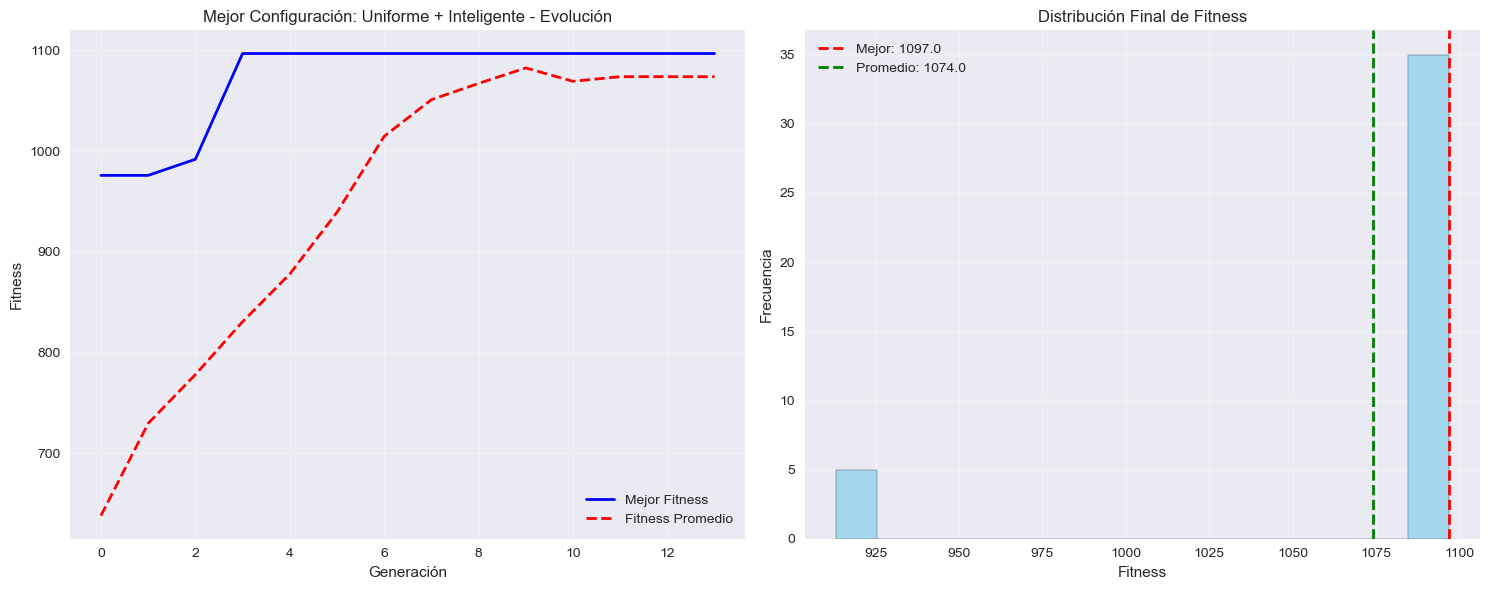

In [57]:
def graficar_evolucion_fitness(algoritmo, titulo="Evolución del Fitness"):
    """Grafica la evolución del fitness a lo largo de las generaciones"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    generaciones = range(len(algoritmo.historial_mejor_fitness))
    
    # Gráfico 1: Evolución del mejor fitness y promedio
    ax1.plot(generaciones, algoritmo.historial_mejor_fitness, 'b-', linewidth=2, label='Mejor Fitness')
    ax1.plot(generaciones, algoritmo.historial_fitness_promedio, 'r--', linewidth=2, label='Fitness Promedio')
    ax1.set_xlabel('Generación')
    ax1.set_ylabel('Fitness')
    ax1.set_title(f'{titulo} - Evolución')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Gráfico 2: Distribución de fitness en la última generación
    if algoritmo.historial_fitness:
        fitness_final = algoritmo.historial_fitness[-1]
        ax2.hist(fitness_final, bins=15, alpha=0.7, color='skyblue', edgecolor='black')
        ax2.axvline(algoritmo.mejor_individuo.fitness, color='red', linestyle='--', 
                   linewidth=2, label=f'Mejor: {algoritmo.mejor_individuo.fitness:.1f}')
        ax2.axvline(np.mean(fitness_final), color='green', linestyle='--', 
                   linewidth=2, label=f'Promedio: {np.mean(fitness_final):.1f}')
        ax2.set_xlabel('Fitness')
        ax2.set_ylabel('Frecuencia')
        ax2.set_title('Distribución Final de Fitness')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def graficar_comparacion_experimentos(resultados_dict, titulo="Comparación de Experimentos"):
    """Compara los resultados de diferentes experimentos"""
    
    nombres = list(resultados_dict.keys())
    mejores_fitness = [res['mejor_fitness'] for res in resultados_dict.values()]
    restricciones_incumplidas = [res['restricciones_obligatorias'] for res in resultados_dict.values()]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Gráfico 1: Comparación de mejor fitness
    bars1 = ax1.bar(nombres, mejores_fitness, color='lightblue', alpha=0.8, edgecolor='navy')
    ax1.set_ylabel('Mejor Fitness')
    ax1.set_title('Comparación de Mejor Fitness')
    ax1.tick_params(axis='x', rotation=45)
    
    # Agregar valores en las barras
    for bar, fitness in zip(bars1, mejores_fitness):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 5,
                f'{fitness:.1f}', ha='center', va='bottom')
    
    # Gráfico 2: Comparación de restricciones incumplidas
    colors = ['green' if r == 0 else 'orange' if r <= 2 else 'red' for r in restricciones_incumplidas]
    bars2 = ax2.bar(nombres, restricciones_incumplidas, color=colors, alpha=0.8)
    ax2.set_ylabel('Restricciones Obligatorias incumplidas')
    ax2.set_title('Restricciones Obligatorias incumplidas')
    ax2.tick_params(axis='x', rotation=45)
    
    # Agregar valores en las barras
    for bar, restricciones in zip(bars2, restricciones_incumplidas):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                f'{restricciones}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# Graficar resultados del mejor experimento
mejor_experimento = max(resultados_operadores.items(), key=lambda x: x[1]['mejor_fitness'])
print(f"Mejor configuración: {mejor_experimento[0]}")

graficar_evolucion_fitness(mejor_experimento[1]['algoritmo'], 
                          f"Mejor Configuración: {mejor_experimento[0]}")

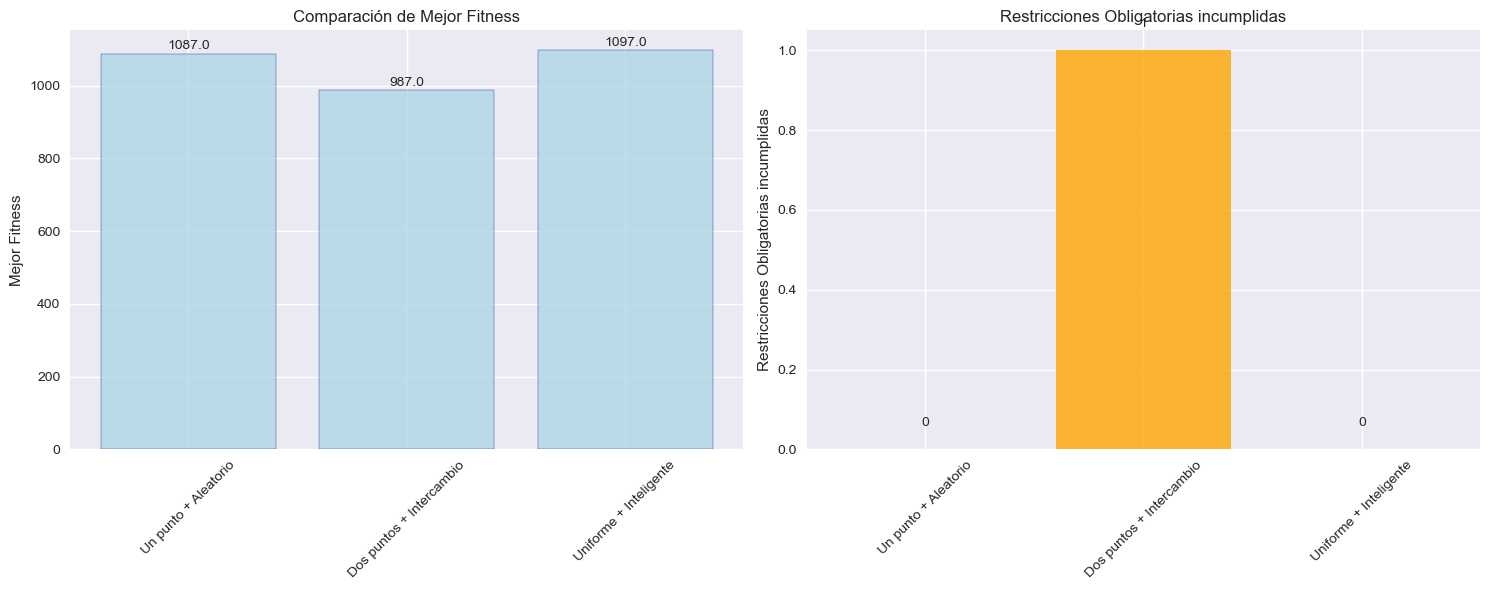

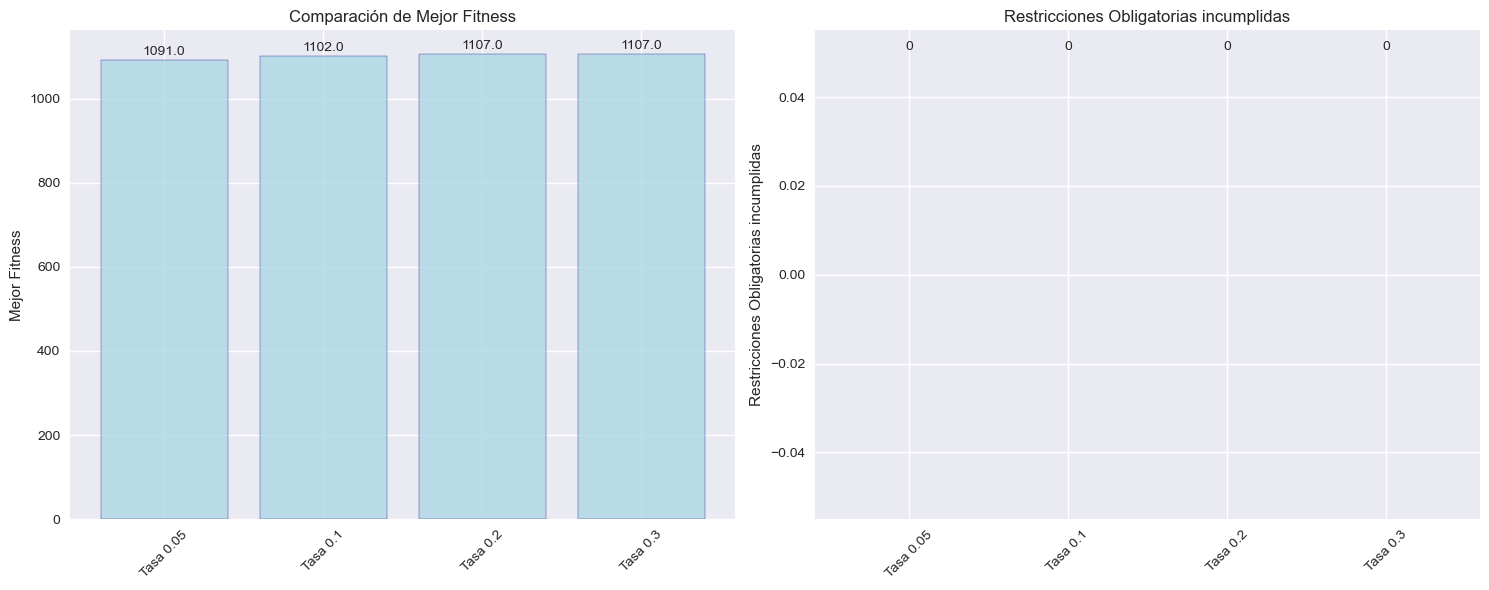

In [55]:
# Graficar comparaciones
graficar_comparacion_experimentos(resultados_operadores, "Comparación de Operadores Genéticos")

# Preparar datos para comparación de tasas de mutación
resultados_tasas_viz = {f"Tasa {k}": v for k, v in resultados_tasas.items()}
graficar_comparacion_experimentos(resultados_tasas_viz, "Comparación de Tasas de Mutación")

In [54]:
def visualizar_cronograma(individuo, titulo="Cronograma de Clases"):
    """Visualiza el cronograma de clases de forma clara"""
    
    cronograma = individuo.obtener_cronograma_completo()
    df_cronograma = pd.DataFrame(cronograma)
    
    print(f"\n=== {titulo} ===")
    print(f"Fitness: {individuo.fitness}")
    print(f"Restricciones obligatorias incumplidas: {individuo.restricciones_incumplidas['obligatorias']}")
    print(f"Restricciones opcionales incumplidas: {individuo.restricciones_incumplidas['opcionales']}")
    
    # Crear tabla resumida
    tabla_resumen = df_cronograma[['curso_id', 'curso', 'cantidad_alumnos', 
                                  'aula_id', 'capacidad', 'profesor_id', 'horario_id']].copy()
    
    # Agregar columna de eficiencia de aula
    tabla_resumen['eficiencia_aula'] = (tabla_resumen['cantidad_alumnos'] / 
                                       tabla_resumen['capacidad'] * 100).round(1)
    
    print("\n--- Cronograma Detallado ---")
    print(tabla_resumen.to_string(index=False))
    
    # Crear visualización de ocupación por horario
    print("\n--- Ocupación por Horario ---")
    for horario_id in horarios_ids:
        clases_horario = df_cronograma[df_cronograma['horario_id'] == horario_id]
        if not clases_horario.empty:
            print(f"\n{horario_id} ({horarios_dict[horario_id]}):")
            for _, clase in clases_horario.iterrows():
                print(f"  • {clase['curso_id']} - {clase['aula_id']} - {clase['profesor_id']}")
    
    # Crear visualización de carga por profesor
    print("\n--- Carga por Profesor ---")
    carga_profesores = df_cronograma.groupby('profesor_id').size()
    for profesor_id, num_clases in carga_profesores.items():
        profesor_nombre = profesores_dict[profesor_id]
        print(f"{profesor_id} ({profesor_nombre}): {num_clases} clase(s)")
    
    return tabla_resumen

# Visualizar el mejor cronograma encontrado
mejor_algoritmo = mejor_experimento[1]['algoritmo']
tabla_mejor = visualizar_cronograma(mejor_algoritmo.mejor_individuo, 
                                   "MEJOR CRONOGRAMA ENCONTRADO")


=== MEJOR CRONOGRAMA ENCONTRADO ===
Fitness: 1097
Restricciones obligatorias incumplidas: 0
Restricciones opcionales incumplidas: 2

--- Cronograma Detallado ---
curso_id                       curso  cantidad_alumnos aula_id  capacidad profesor_id horario_id  eficiencia_aula
    C001 Fundamentos de programación                45    A001         45        P003       H002            100.0
    C002              Bases de Datos                45    A001         45        P004       H004            100.0
    C003                  Algoritmia                35    A002         35        P002       H001            100.0
    C004     Sistemas de información                30    A002         35        P004       H002             85.7
    C005   Sistemas de Información 2                30    A002         35        P003       H003             85.7
    C006            Machine Learning                25    A003         25        P001       H001            100.0
    C007               Deep Learning   

## 8. Análisis de Convergencia

=== ANÁLISIS DE CONVERGENCIA ===
Generaciones totales: 14
Fitness inicial: 976.00
Fitness final: 1097.00
Mejora total: 121.00
Estancamiento detectado en generación: 8
Diversidad inicial: 175.43
Diversidad final: 60.85


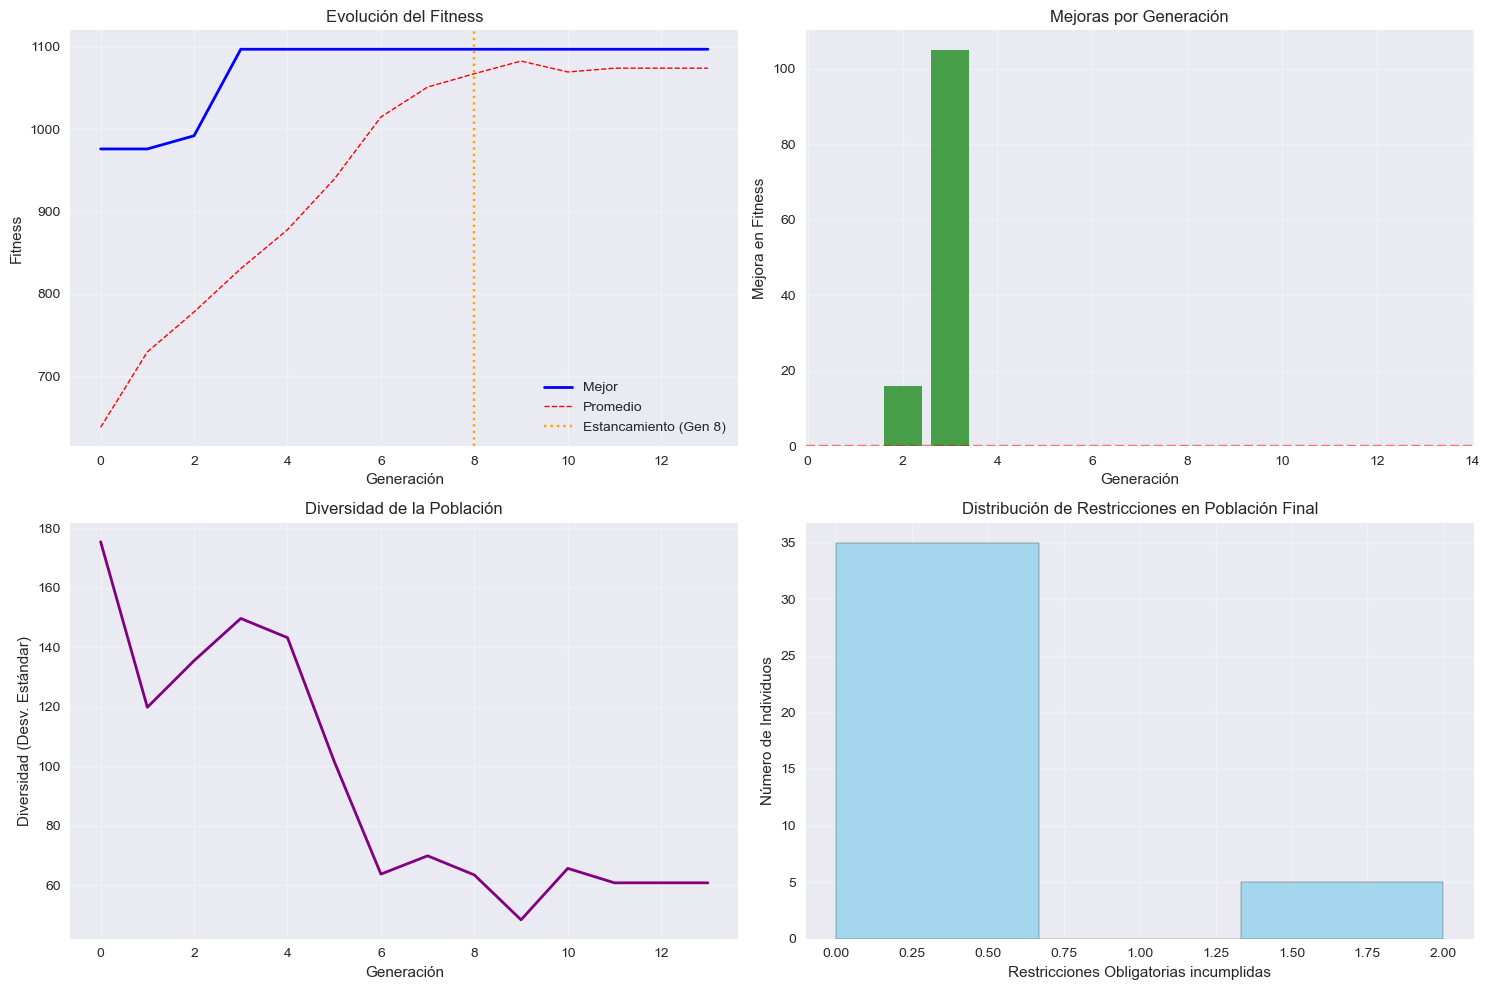

In [53]:
def analizar_convergencia(algoritmo, ventana=5):
    """Analiza la convergencia del algoritmo genético"""
    
    print("=== ANÁLISIS DE CONVERGENCIA ===")
    
    # Calcular mejora por generación
    mejoras = []
    for i in range(1, len(algoritmo.historial_mejor_fitness)):
        mejora = algoritmo.historial_mejor_fitness[i] - algoritmo.historial_mejor_fitness[i-1]
        mejoras.append(mejora)
    
    # Detectar estancamiento
    generacion_estancamiento = None
    contador_estancamiento = 0
    for i, mejora in enumerate(mejoras):
        if mejora <= 0:
            contador_estancamiento += 1
            if contador_estancamiento >= ventana and generacion_estancamiento is None:
                generacion_estancamiento = i + 1
        else:
            contador_estancamiento = 0
    
    print(f"Generaciones totales: {len(algoritmo.historial_mejor_fitness)}")
    print(f"Fitness inicial: {algoritmo.historial_mejor_fitness[0]:.2f}")
    print(f"Fitness final: {algoritmo.historial_mejor_fitness[-1]:.2f}")
    print(f"Mejora total: {algoritmo.historial_mejor_fitness[-1] - algoritmo.historial_mejor_fitness[0]:.2f}")
    
    if generacion_estancamiento:
        print(f"Estancamiento detectado en generación: {generacion_estancamiento}")
    else:
        print("No se detectó estancamiento significativo")
    
    # Calcular diversidad de la población (desviación estándar del fitness)
    diversidades = []
    for fitness_gen in algoritmo.historial_fitness:
        diversidades.append(np.std(fitness_gen))
    
    print(f"Diversidad inicial: {diversidades[0]:.2f}")
    print(f"Diversidad final: {diversidades[-1]:.2f}")
    
    # Graficar análisis de convergencia
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    generaciones = range(len(algoritmo.historial_mejor_fitness))
    
    # Evolución del fitness
    ax1.plot(generaciones, algoritmo.historial_mejor_fitness, 'b-', linewidth=2, label='Mejor')
    ax1.plot(generaciones, algoritmo.historial_fitness_promedio, 'r--', linewidth=1, label='Promedio')
    if generacion_estancamiento:
        ax1.axvline(generacion_estancamiento, color='orange', linestyle=':', 
                   label=f'Estancamiento (Gen {generacion_estancamiento})')
    ax1.set_xlabel('Generación')
    ax1.set_ylabel('Fitness')
    ax1.set_title('Evolución del Fitness')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Mejoras por generación
    if mejoras:
        ax2.bar(range(1, len(mejoras)+1), mejoras, alpha=0.7, color='green')
        ax2.axhline(0, color='red', linestyle='--', alpha=0.5)
        ax2.set_xlabel('Generación')
        ax2.set_ylabel('Mejora en Fitness')
        ax2.set_title('Mejoras por Generación')
        ax2.grid(True, alpha=0.3)
    
    # Diversidad de la población
    ax3.plot(generaciones, diversidades, 'purple', linewidth=2)
    ax3.set_xlabel('Generación')
    ax3.set_ylabel('Diversidad (Desv. Estándar)')
    ax3.set_title('Diversidad de la Población')
    ax3.grid(True, alpha=0.3)
    
    # Distribución de restricciones incumplidas en población final
    if algoritmo.poblacion:
        restricciones_poblacion = [ind.restricciones_incumplidas['obligatorias'] for ind in algoritmo.poblacion]
        ax4.hist(restricciones_poblacion, bins=max(1, max(restricciones_poblacion)+1), 
                alpha=0.7, color='skyblue', edgecolor='black')
        ax4.set_xlabel('Restricciones Obligatorias incumplidas')
        ax4.set_ylabel('Número de Individuos')
        ax4.set_title('Distribución de Restricciones en Población Final')
        ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'generacion_estancamiento': generacion_estancamiento,
        'mejora_total': algoritmo.historial_mejor_fitness[-1] - algoritmo.historial_mejor_fitness[0],
        'diversidad_inicial': diversidades[0],
        'diversidad_final': diversidades[-1],
        'convergencia_completa': algoritmo.mejor_individuo.restricciones_incumplidas['obligatorias'] == 0
    }

# Analizar convergencia del mejor algoritmo
analisis_convergencia = analizar_convergencia(mejor_algoritmo)